# Flow Field in PFR

## Contents

- [Simple](#simple)
- [Revision and Optimization](revision_and_optimization)

In [1]:
using LinearAlgebra, LinearSolve, Plots, LaTeXStrings

ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Warning: Module SciMLBase with build ID ffffffff-ffff-ffff-0005-e1a8f17e7dca is missing from the cache.
│ This may mean SciMLBase [0bca4576-84f4-4d90-8ffe-ffa030f20462] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:2541
┌ Warning: Module LinearSolve with build ID ffffffff-ffff-ffff-0005-e1a5ded2e0e1 is missing from the cache.
│ This may mean LinearSolve [7ed4a6bd-45f5-4d41-b270-4a48e9bafcae] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:2541


## Simple

In [ ]:
# Problem specs
L = 10.
v_in = 0.1
p_out = 1e5
Mw = 1e-3
mu = 2e-5
dp = 3e-2
T = 300.
R = 8.314
rho_out = p_out * Mw / (R * T)
eps_b = 0.5
function calc_f(eps_b, rho, v, dp, mu)
    Rep = (rho*abs(v+1e-10)*dp) / mu
    f = 6.8 * (((1-eps_b)^1.2) / (eps_b^3)) * Rep^(-0.2)
    return f
end

# Discretization
Nz = 100
dz = L / (Nz+0.5)
t = 0.
tf = 1.
dt = 0.01
t_vec = range(t, tf, 7)

# Preparing solution vectors
vzt_mat = zeros((Nz+1, length(t_vec)))
pzt_mat = copy(vzt_mat)
vzt_mat[1, :] .= v_in
pzt_mat[end, :] .= p_out;

In [8]:
# Initial condition and initial guess
v0 = zeros(Nz)
p0 = ones(Nz) * p_out
v = copy(v0)
p = copy(p0)
vzt_mat[2:end, 1] = v0
pzt_mat[1:end-1, 1] = p0
p_s = range(1.1*p_out, p_out, Nz)

# Iteration settings
i_t = 2
atol = 1e-8
jmax = 100
alpha_v_s = 0.7
alpha_p = 0.6

0.6

In [ ]:
# Solving the problem

while t<tf

    # Updating previous time step
    v0 = copy(v)
    p0 = copy(p)
    rho0 = @. p0 * Mw / (R * T)
    rho0_out = p_out * Mw / (R * T)
    rho0_m = @. (rho0[2:end] + rho0[1:end-1]) / 2.0
    append!(rho0_m, (rho0[end]+rho0_out)/2.0)

    j = 0
    vj0 = copy(v)

    while j < jmax

        # Calculating intermediates
        rho_s = @. p_s * Mw / (R * T)
        rho_out = p_out * Mw / (R * T)
        rho_m = @. (rho_s[2:end] + rho_s[1:end-1]) / 2.0
        append!(rho_m, (rho_s[end]+rho_out)/2.0)
        F_m = @. 1/(eps_b^2) * 0.5*(vj0[2:end] + vj0[1:end-1]) * rho_s[2:end]
        insert!(F_m, 1, 1/(eps_b^2) * 0.5*(vj0[1] + v_in) * rho_s[1])
        F_out = F_m[end] - 0.5*dz/dt * 1/(eps_b^2) * (rho_out - rho0_out)

        aE = zeros(Nz)
        aW = zeros(Nz)
        aP_v = zeros(Nz)
        b = zeros(Nz)

        # Setting Coefficients
        ## Lower BC
        z = 1
        f = calc_f(eps_b, rho_m[z], vj0[z], dp, mu)
        S_P = - f * rho_m[z] * abs(vj0[z]) / dp
        aW[z] = maximum([F_m[z], 0.0])
        aE[z] = maximum([-F_m[z+1], 0.0])
        aP_v[z] = aE[z] + aW[z] + (F_m[z+1] - F_m[z]) + (rho_m[z]*dz)/(eps_b*dt) - S_P*dz
        aP0 = (rho0_m[z] * dz) / (eps_b * dt)
        b[z] = aP0 * v0[z] + (p_s[z] - p_s[z+1]) + aW[1] * v_in  

        ## Midpoints
        for z in 2:Nz-1
            f = calc_f(eps_b, rho_m[z], vj0[z], dp, mu)
            S_P = - f * rho_m[z] * abs(vj0[z]) / dp
            aW[z] = maximum([F_m[z], 0.0])
            aE[z] = maximum([-F_m[z+1], 0.0])
            aP_v[z] = aE[z] + aW[z] + (F_m[z+1] - F_m[z]) + (rho_m[z]*dz)/(eps_b*dt) - S_P*dz
            aP0 = (rho0_m[z] * dz) / (eps_b * dt)
            b[z] = aP0 * v0[z] + (p_s[z] - p_s[z+1])
        end                                            

        ## Upper BC
        z = Nz
        f = calc_f(eps_b, rho_m[z], vj0[z], dp, mu)
        S_P = - f * rho_m[z] * abs(vj0[z]) / dp
        aW[z] = maximum([F_m[z], 0.0])
        aE[z] = maximum([-F_out, 0.0])
        aP_v[z] = aE[z] + aW[z] + (F_out - F_m[z]) + (rho_m[z]*dz)/(eps_b*dt) - S_P*dz
        aP0 = (rho0_m[z] * dz) / (eps_b * dt)
        b[z] = aP0 * v0[z] + (p_s[z] - p_out)

        # Assemble and solve
        A = Tridiagonal(-aW[2:end], aP_v, -aE[1:end-1])
        prob = LinearProblem(A, b)
        sol = solve(prob)
        v_s = @. (1-alpha_v_s) * v + alpha_v_s * sol.u

        aE = zeros(Nz)
        aW = zeros(Nz)
        aP = zeros(Nz)
        b = zeros(Nz)

        # Setting coefficients
        ## Upper BC
        z = 1
        aE[z] = rho_m[z] / aP_v[z]
        aW[z] = 0.0
        aP[z] = aE[z] + aW[z]
        b[z] = eps_b * (rho0[z] - rho_s[z]) * dz / dt + rho_s[1]*v_in - rho_m[z]*v_s[z]
        
        ## Midpoints
        for z in 2:Nz
            aE[z] = rho_m[z] / aP_v[z]
            aW[z] = rho_m[z-1] / aP_v[z-1]
            aP[z] = aE[z] + aW[z]
            b[z] = eps_b * (rho0[z] - rho_s[z]) * dz / dt + rho_m[z-1]*v_s[z-1] - rho_m[z]*v_s[z]
        end

        A = Tridiagonal(-aW[2:end], aP, -aE[1:end-1])
        prob = LinearProblem(A, b)
        sol = solve(prob)
        p_d = sol.u
        
        # ------------------ Update ------------------
        ## Apply corrections
        p = @. p_s + alpha_p * p_d
        v[1:end-1] = @. v_s[1:end-1] + 1/aP_v[1:end-1] * (p_d[1:end-1] - p_d[2:end])
        v[end] = v_s[end] + 1/aP_v[end] * (p_d[end] - 0.0)

        ## Checking convergence criteria
        if norm(v-v_s, 2) < atol && norm(p-p_s, 2) < atol
            println(j)
            break
        end
        
        ## Update guesses for next iteration
        p_s = copy(p)
        vj0 = copy(v)
        j += 1

    end

    # Save solution
    if t > t_vec[i_t]
        vzt_mat[2:end, i_t] = v
        pzt_mat[1:end-1, i_t] = p
        i_t += 1
    end

    t += dt
end
    
# Saving final time step
vzt_mat[2:end, i_t] = v
pzt_mat[1:end-1, i_t] = p;

45
34
30
27
26
25
19
22
20
16
18
16
13
13
11
9
9
6
5
5
2
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0

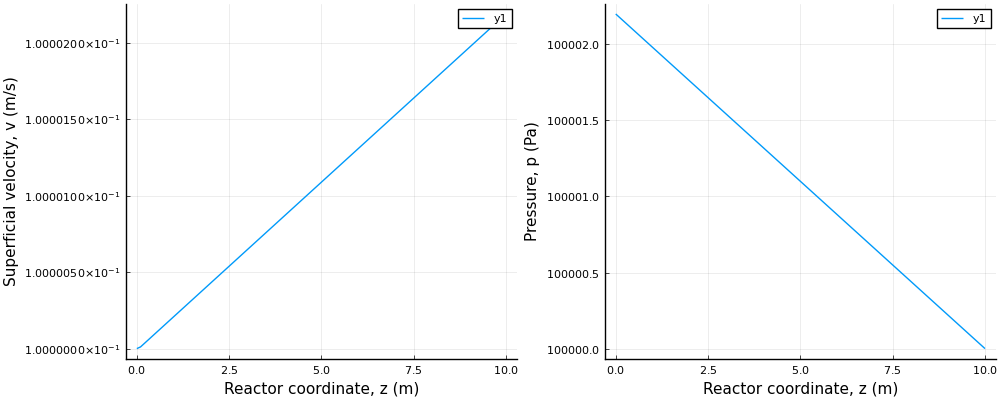

In [10]:
pythonplot()

z_vec = range(0, L, Nz+1)
plt1 = plot(z_vec, vzt_mat[1:end, end], xlabel="Reactor coordinate, z (m)", ylabel="Superficial velocity, v (m/s)")
plt2 = plot(z_vec, pzt_mat[1:end, end], xlabel="Reactor coordinate, z (m)", ylabel="Pressure, p (Pa)")
plot(plt1, plt2, layout=grid(1,2), size=(1000, 400))

In [11]:
function calc_ints(rho_s, rho_m, F_m, vj0, p_s, pars)

    v_in, eps_b, Mw, R, T, rho0_out = pars

    z = 1
    rho_s[z] = p_s[z] * Mw / (R * T)
    F_m[z] = 1/(eps_b^2) * 0.5*(vj0[1] + v_in) * rho_s[1]

    for z in 1:Nz-1
        rho_s[z+1] = p_s[z+1] * Mw / (R * T)
        rho_m[z] = (rho_s[z+1] + rho_s[z]) / 2.0
        F_m[z+1] = 1/(eps_b^2) * 0.5*(vj0[z+1] + vj0[z]) * rho_s[z+1]
    end

    z = Nz
    rho_out = p_out * Mw / (R * T)
    rho_m[z] = (rho_s[end]+rho_out)/2.0
    F_out = F_m[z] - 0.5*dz/dt * 1/(eps_b^2) * (rho_out - rho0_out)

    return F_out
end


function momentum!(aP_v, v_s, aW, aE, A, b, v0, vj0, v, p_s, F_m, rho_m, rho0_m, linsolve, pars)

    eps_b, dp, mu, v_in, p_out, F_out, alpha_v_s, dz, dt = pars
    
    # Setting Coefficients
    ## Lower BC
    z = 1
    f = calc_f(eps_b, rho_m[z], vj0[z], dp, mu)
    S_P = - f * rho_m[z] * abs(vj0[z]) / dp
    aW[z] = maximum([F_m[z], 0.0])
    aE[z] = maximum([-F_m[z+1], 0.0])
    aP_v[z] = aE[z] + aW[z] + (F_m[z+1] - F_m[z]) + (rho_m[z]*dz)/(eps_b*dt) - S_P*dz
    aP0 = (rho0_m[z] * dz) / (eps_b * dt)
    b[z] = aP0 * v0[z] + (p_s[z] - p_s[z+1]) + aW[1] * v_in  

    ## Midpoints
    for z in 2:Nz-1
        f = calc_f(eps_b, rho_m[z], vj0[z], dp, mu)
        S_P = - f * rho_m[z] * abs(vj0[z]) / dp
        aW[z] = maximum([F_m[z], 0.0])
        aE[z] = maximum([-F_m[z+1], 0.0])
        aP_v[z] = aE[z] + aW[z] + (F_m[z+1] - F_m[z]) + (rho_m[z]*dz)/(eps_b*dt) - S_P*dz
        aP0 = (rho0_m[z] * dz) / (eps_b * dt)
        b[z] = aP0 * v0[z] + (p_s[z] - p_s[z+1])
    end                                            

    ## Upper BC
    z = Nz
    f = calc_f(eps_b, rho_m[z], vj0[z], dp, mu)
    S_P = - f * rho_m[z] * abs(vj0[z]) / dp
    aW[z] = maximum([F_m[z], 0.0])
    aE[z] = maximum([-F_out, 0.0])
    aP_v[z] = aE[z] + aW[z] + (F_out - F_m[z]) + (rho_m[z]*dz)/(eps_b*dt) - S_P*dz
    aP0 = (rho0_m[z] * dz) / (eps_b * dt)
    b[z] = aP0 * v0[z] + (p_s[z] - p_out)

    # Assemble and solve
    A[:,:] = Tridiagonal(-aW[2:end], aP_v, -aE[1:end-1])
    linsolve.A = A
    linsolve.b = b
    sol = solve!(linsolve)

    for z in 1:Nz
        v_s[z] = (1-alpha_v_s) * v[z] + alpha_v_s * sol.u[z]
    end

    return nothing
end


function pressure_corr!(p, v, aW, aE, aP, A, b, rho_m, aP_v, rho0, rho_s, v_s, p_s, linsolve, pars)

    eps_b, v_in, alpha_p, dz, dt = pars

    # Setting coefficients
    ## Upper BC
    z = 1
    aE[z] = rho_m[z] / aP_v[z]
    aW[z] = 0.0
    aP[z] = aE[z] + aW[z]
    b[z] = eps_b * (rho0[z] - rho_s[z]) * dz / dt + rho_s[1]*v_in - rho_m[z]*v_s[z]
    
    ## Midpoints
    for z in 2:Nz
        aE[z] = rho_m[z] / aP_v[z]
        aW[z] = rho_m[z-1] / aP_v[z-1]
        aP[z] = aE[z] + aW[z]
        b[z] = eps_b * (rho0[z] - rho_s[z]) * dz / dt + rho_m[z-1]*v_s[z-1] - rho_m[z]*v_s[z]
    end

    ## Solving
    A[:,:] = Tridiagonal(-aW[2:end], aP, -aE[1:end-1])
    linsolve.A = A
    linsolve.b = b
    sol = solve!(linsolve)

    # Applying corrections
    ## Midpoints
    for z in 1:Nz-1
        p_d = sol.u[z]
        p_d_up = sol.u[z+1]
        p[z] = p_s[z] + alpha_p * p_d
        v[z] = v_s[z] + 1/aP_v[z] * (p_d - p_d_up)
    end

    ## Upper BC
    z = Nz
    p_d = sol.u[z]
    p[z] = p_s[z] + alpha_p * p_d
    v[z] = v_s[z] + 1/aP_v[z] * (p_d - 0.0)

    return nothing
end

pressure_corr! (generic function with 1 method)

In [ ]:
# Problem specs
Nz = 100
L = 10.
dz = L / (Nz+0.5)
v_in = 0.1
p_out = 1e5
Mw = 1e-3
mu = 2e-5
dp = 3e-2
T = 300.
R = 8.314
eps_b = 0.5
function calc_f(eps_b, rho, v, dp, mu)
    Rep = (rho*abs(v+1e-10)*dp) / mu
    f = 6.8 * (((1-eps_b)^1.2) / (eps_b^3)) * Rep^(-0.2)
    return f
end

tf = 1.0
dt = 0.01
t_vec = range(0.0, tf, 7)
vzt_mat = zeros((Nz+1, length(t_vec)))
pzt_mat = copy(vzt_mat)
vzt_mat[1, :] .= v_in
pzt_mat[end, :] .= p_out;

In [24]:
# Initial condition and initial guess
v0 = zeros(Nz)
p0 = ones(Nz) * p_out
vzt_mat[2:end, 1] = copy(v0)
pzt_mat[1:end-1, 1] = copy(p0)
p_s = range(1.1*p_out, p_out, Nz)

atol = 1e-8
jmax = 100
alpha_v_s = 0.7
alpha_p = 0.6

0.6

In [25]:
aE = zeros(Nz)
aW = zeros(Nz)
aP = zeros(Nz)
aP_v = zeros(Nz)
v_s = zeros(Nz)
rho0 = zeros(Nz)
rho_s = zeros(Nz)
rho_m = zeros(Nz)
rho0_m = zeros(Nz)
F_m = zeros(Nz)
A = Tridiagonal(-ones(Nz-1), ones(Nz), -ones(Nz-1))
b = ones(Nz)
prob = LinearProblem(A, b)
linsolve = init(prob)

t = 0.0
i_t = 2
vj0 = copy(v0)
v = copy(v0)
p = copy(p0)

while t<tf

    # Updating previous time step
    v0 = copy(v)
    p0 = copy(p)

    z = 1
    rho0[z] = p0[z] * Mw / (R * T)

    for z in 2:Nz
        rho0[z] = p0[z] * Mw / (R * T)
        rho0_m[z-1] = (rho0[z-1] + rho0[z]) / 2.0
    end

    z = Nz
    rho0_out = p_out * Mw / (R * T)
    rho0_m[z] = (rho0[end] + rho0_out) / 2.0

    j = 0
    while j < jmax

        # Calculating intermediates
        pars1 = (v_in, eps_b, Mw, R, T, rho0_out)
        F_out = calc_ints(rho_s, rho_m, F_m, vj0, p_s, pars1)
    
        pars2 = (eps_b, dp, mu, v_in, p_out, F_out, alpha_v_s, dz, dt)
        momentum!(aP_v, v_s, aW, aE, A, b, v0, vj0, v, p_s, F_m, rho_m, rho0_m, linsolve, pars2)

        pars3 = (eps_b, v_in, alpha_p, dz, dt)
        pressure_corr!(p, v, aW, aE, aP, A, b, rho_m, aP_v, rho0, rho_s, v_s, p_s, linsolve, pars3)

        ## Update guesses for next iteration
        p_s = copy(p)
        vj0 = copy(v)
        j += 1

        ## Checking convergence criteria
        if norm(v-v_s, 2) < atol && norm(p-p_s, 2) < atol
            # println(j)
            break
        end

    end

    # Save solution
    if t >= t_vec[i_t]
        vzt_mat[2:end, i_t] = v
        pzt_mat[1:end-1, i_t] = p
        i_t += 1
    end

    t += dt
end
    
# Saving final time step
vzt_mat[2:end, i_t] = v
pzt_mat[1:end-1, i_t] = p;

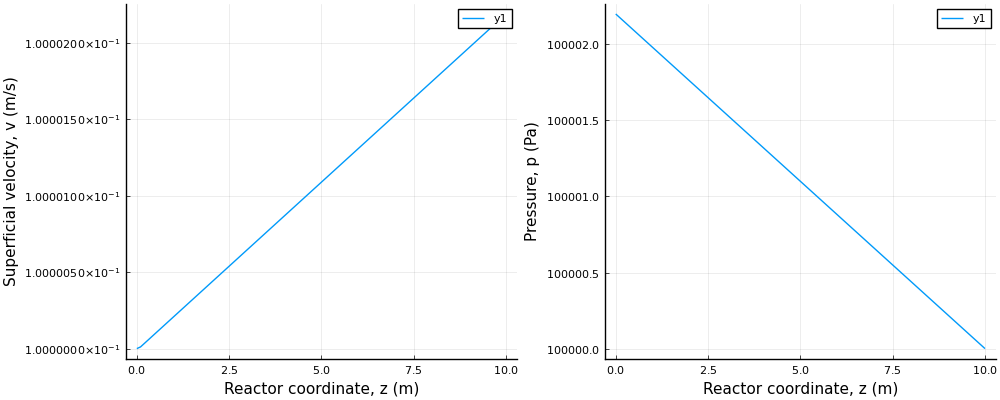

In [26]:
z_vec = range(0, L, Nz+1)
plt1 = plot(z_vec, vzt_mat[1:end, end], xlabel="Reactor coordinate, z (m)", ylabel="Superficial velocity, v (m/s)")
plt2 = plot(z_vec, pzt_mat[1:end, end], xlabel="Reactor coordinate, z (m)", ylabel="Pressure, p (Pa)")
plot(plt1, plt2, layout=grid(1,2), size=(1000, 400))

In [29]:
# Solving the problem

function solve_PDE!(vzt_mat, pzt_mat, v0, p0, p_s, pars)

    Mw, R, T, p_out, v_in, eps_b, mu, dp, t_vec, dt, Nz, dz, atol, jmax, alpha_v_s, alpha_p = pars
    tf = t_vec[end]

    aE = zeros(Nz)
    aW = zeros(Nz)
    aP = zeros(Nz)
    aP_v = zeros(Nz)
    v_s = zeros(Nz)
    rho0 = zeros(Nz)
    rho_s = zeros(Nz)
    rho_m = zeros(Nz)
    rho0_m = zeros(Nz)
    F_m = zeros(Nz)
    A = Tridiagonal(-ones(Nz-1), ones(Nz), -ones(Nz-1))
    b = ones(Nz)
    prob = LinearProblem(A, b)
    linsolve = init(prob)

    t = 0.0
    i_t = 2
    v = copy(v0)
    p = copy(p0)

    while t<tf

        # Updating previous time step
        v0 = copy(v)
        p0 = copy(p)

        z = 1
        rho0[z] = p0[z] * Mw / (R * T)

        for z in 2:Nz
            rho0[z] = p0[z] * Mw / (R * T)
            rho0_m[z-1] = (rho0[z-1] + rho0[z]) / 2.0
        end

        z = Nz
        rho0_out = p_out * Mw / (R * T)
        rho0_m[z] = (rho0[end] + rho0_out) / 2.0

        j = 0
        vj0 = copy(v0)

        while j < jmax

            # Calculating intermediates
            pars1 = (v_in, eps_b, Mw, R, T, rho0_out)
            F_out = calc_ints(rho_s, rho_m, F_m, vj0, p_s, pars1)

            pars2 = (eps_b, dp, mu, v_in, p_out, F_out, alpha_v_s, dz, dt)
            momentum!(aP_v, v_s, aW, aE, A, b, v0, vj0, v, p_s, F_m, rho_m, rho0_m, linsolve, pars2)

            pars3 = (eps_b, v_in, alpha_p, dz, dt)
            pressure_corr!(p, v, aW, aE, aP, A, b, rho_m, aP_v, rho0, rho_s, v_s, p_s, linsolve, pars3)

            ## Checking convergence criteria
            if norm(v-v_s, 2) < atol && norm(p-p_s, 2) < atol
                println(j)
                break
            end
            
            ## Update guesses for next iteration
            p_s = copy(p)
            vj0 = copy(v)
            j += 1

        end

        # Save solution
        if t >= t_vec[i_t]
            vzt_mat[2:end, i_t] = v
            pzt_mat[1:end-1, i_t] = p
            i_t += 1
        end

        t += dt
    end
        
    # Saving final time step
    vzt_mat[2:end, i_t] = v
    pzt_mat[1:end-1, i_t] = p

    return nothing
end

solve_PDE! (generic function with 1 method)

In [30]:
# Initial condition and initial guess
v0 = zeros(Nz)
p0 = ones(Nz) * p_out
vzt_mat[2:end, 1] = copy(v0)
pzt_mat[1:end-1, 1] = copy(p0)
p_s = range(1.1*p_out, p_out, Nz)

vzt_mat = zeros((Nz+1, length(t_vec)))
pzt_mat = copy(vzt_mat)
vzt_mat[1, :] .= v_in
pzt_mat[end, :] .= p_out;

atol = 1e-8
jmax = 100
alpha_v_s = 0.5
alpha_p = 0.8

pars = (Mw, R, T, p_out, v_in, eps_b, mu, dp, t_vec, dt, Nz, dz, atol, jmax, alpha_v_s, alpha_p)
solve_PDE!(vzt_mat, pzt_mat, v0, p0, p_s, pars)

In [ ]:
z_vec = range(0, L, Nz+1)
plt1 = plot(z_vec, vzt_mat[1:end, end], xlabel="Reactor coordinate, z (m)", ylabel="Superficial velocity, v (m/s)")
plt2 = plot(z_vec, pzt_mat[1:end, end], xlabel="Reactor coordinate, z (m)", ylabel="Pressure, p (Pa)")
plot(plt1, plt2, layout=grid(1,2), size=(1000, 400))